# Functions and libraries

In [1]:
import torch
import agama
import numpy as np 
from torchdiffeq import odeint
from scipy.optimize import root_scalar
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl

agama.setUnits(mass=1, length=1, velocity=1)

# Setting up the axisymmetric potential parameters
st_disk = agama.Potential(type="Disk", surfaceDensity=1.1881428440377242e9, scaleRadius=2.4, scaleHeight=0.3)
ISM_disk = agama.Potential(type="Disk", surfaceDensity=0.07177198075221586e9, scaleRadius=4.8, scaleHeight=0.130)
DM_pot = agama.Potential(type="Spheroid", densityNorm=4.56e8, axisRatioZ=0.8, gamma=0., beta=0., scaleRadius=1., outerCutoffRadius=0.65, cutoffStrength=0.499)
bulge_pot = agama.Potential(type="Spheroid", densityNorm=1.0834e8, axisRatioZ=1, gamma=1.30367551, beta=2.90665262, scaleRadius=8.15813067, outerCutoffRadius=0.83073304)

p = agama.Potential(st_disk, ISM_disk, DM_pot, bulge_pot)
af = agama.ActionFinder(p)

# Bar potential
def potential_bar(R, phi, m, A, a, b, phib, Omegab, R_cutoff, t):
    return A * (1 - R / R_cutoff).clamp(0, 1).pow(b - 1) * (R / R_cutoff).pow(a - 1) * torch.cos(m * (phi - phib - Omegab * t))

def potential_bar_deriv_R(R, phi, m, A, a, b, phib, Omegab, R_cutoff, t):
    return A * (1 - R / R_cutoff).clamp(0, 1).pow(b - 2) * (R / R_cutoff).pow(a - 2) * torch.cos(m * (phi - phib - Omegab * t)) * ((a - 1) * (1 - R / R_cutoff) - (b - 1) * R / R_cutoff) / R_cutoff

def potential_bar_deriv_phi(R, phi, m, A, a, b, phib, Omegab, R_cutoff, t):
    return -A * m * (1 - R / R_cutoff).clamp(0, 1).pow(b - 1) * (R / R_cutoff).pow(a - 1) * torch.sin(m * (phi - phib - Omegab * t))

def potential_bar_force(x, y, R, phi, mpars, phib, Omegab, R_cutoff, t):
    modes = [2, 4, 6]
    mode_sum = sum([potential_bar(R, phi, mode, mpars[int(mode/2) - 1, 0], mpars[int(mode/2) - 1, 1], mpars[int(mode/2) - 1, 2], phib, Omegab, R_cutoff, t) for mode in modes])
    x_np = x.cpu().numpy()
    y_np = y.cpu().numpy()
    p_force_x = torch.tensor(p.force(np.array([x_np, y_np, np.zeros(x_np.shape)]).T).T[0])
    p_force_y = torch.tensor(p.force(np.array([x_np, y_np, np.zeros(x_np.shape)]).T).T[1])
    
    deriv_R_sum = sum([potential_bar_deriv_R(R, phi, mode, mpars[int(mode/2) - 1, 0], mpars[int(mode/2) - 1, 1], mpars[int(mode/2) - 1, 2], phib, Omegab, R_cutoff, t) for mode in modes])
    deriv_phi_sum = sum([potential_bar_deriv_phi(R, phi, mode, mpars[int(mode/2) - 1, 0], mpars[int(mode/2) - 1, 1], mpars[int(mode/2) - 1, 2], phib, Omegab, R_cutoff, t) for mode in modes])

    force_x = (mode_sum * p_force_x - torch.tensor(p.potential(np.array([x_np, y_np, np.zeros(x_np.shape)]).T).T) * (x / R * deriv_R_sum - y / R / R * deriv_phi_sum))
    force_y = (mode_sum * p_force_y - torch.tensor(p.potential(np.array([x_np, y_np, np.zeros(x_np.shape)]).T).T) * (y / R * deriv_R_sum + x / R / R * deriv_phi_sum))
    
    return force_x, force_y

# Spiral potential
def U(R, pitch_angle, m):
    u = m / (R * torch.sin(pitch_angle))
    return u

def D(R, hs, pitch_angle, m):
    u = U(R, pitch_angle, m)
    uhs = u * hs
    return (1 + uhs + 0.3 * uhs**2) / (1 + 0.3 * uhs)

def deriv_R_core_term(R, hs, pitch_angle, m):
    u = U(R, pitch_angle, m)
    uhs = u * hs
    return uhs * (0.3 - (1 + 0.3 * uhs)**2) / (1 + 0.3 * uhs) / (1 + uhs + 0.3 * uhs**2)

def potential_arms(R, phi, m, K, Omegas, pitch_angle, phi0, R0, R_cutoff, R_outter_cutoff,  hs, t):
    u = U(R, pitch_angle, m)
    d = D(R, hs, pitch_angle, m)
    log_term = torch.log(R / R0) / torch.tan(pitch_angle)
    angle_term = m * (phi - phi0 - Omegas * t + log_term)
    return -K / (R0 * u * d) * (R >= R_cutoff).float() * (R <= R_outter_cutoff).float() * torch.cos(angle_term)

def potential_arms_deriv_R(R, phi, m, K, Omegas, pitch_angle, phi0, R0, R_cutoff, R_outter_cutoff,  hs, t):
    u = U(R, pitch_angle, m)
    d = D(R, hs, pitch_angle, m)
    d_over_d = deriv_R_core_term(R, hs, pitch_angle, m)
    log_term = torch.log(R / R0) / torch.tan(pitch_angle)
    angle_term = m * (phi - phi0 - Omegas * t + log_term)
    return K / (R * R0 * u * d) * (R >= R_cutoff).float() * (R <= R_outter_cutoff).float() * (m / torch.tan(pitch_angle) * torch.sin(angle_term) + (-1 + R * d_over_d) * torch.cos(angle_term))

def potential_arms_deriv_phi(R, phi, m, K, Omegas, pitch_angle, phi0, R0, R_cutoff, R_outter_cutoff,  hs, t):
    u = U(R, pitch_angle, m)
    d = D(R, hs, pitch_angle, m)
    log_term = torch.log(R / R0) / torch.tan(pitch_angle)
    angle_term = m * (phi - phi0 - Omegas * t + log_term)
    return m * K / (R0 * u * d) * (R >= R_cutoff).float() * (R <= R_outter_cutoff).float() * torch.sin(angle_term)

def potential_arms_force(x, y, R, phi, m, K, Omegas, pitch_angle, phi0, R0, R_cutoff, R_outter_cutoff,  hs, t):
    deriv_r = potential_arms_deriv_R(R, phi, m, K, Omegas, pitch_angle, phi0, R0, R_cutoff, R_outter_cutoff,  hs, t) / R
    deriv_phi = potential_arms_deriv_phi(R, phi, m, K, Omegas, pitch_angle, phi0, R0, R_cutoff, R_outter_cutoff,  hs, t) / R**2
    force_x = -(x * deriv_r - y * deriv_phi)
    force_y = -(y * deriv_r + x * deriv_phi)
    return force_x, force_y
	

# Growth function
def val(t, t1, t2):
    Tgrowth = t2 - t1
    condition1 = (t >= t1) & (t <= t2)
    condition2 = t < t1
    condition3 = t > t2
    xi = -2 * ((t - t1) / Tgrowth) + 1
    result = torch.where(condition1, (3/16) * xi**5 - (5/8) * xi**3 + (15/16) * xi + (1/2), torch.where(condition2, 1, torch.where(condition3, 0, torch.zeros_like(t))))
    return result
	
# Force in perturbed potential
def fun_params_vec(mpars, phib, Omegab, R_cutoff_bar, t1, t2, R0, m, K, Omegas, pitch_angle, phi0, R_cutoff_arms, R_outter_cutoff, t3, t4, m_2, K_2, Omegas_2, pitch_angle_2, phi0_2, R_cutoff_arms_2, R_outter_cutoff_2, t3_2, t4_2, hs):
    def fun(t, w):
        v = w.view(4, -1)
        w_0, w_1, w_3, w_4 = v[0], v[1], v[2], v[3]
        R = torch.sqrt(w_0**2 + w_1**2)
        phi = torch.atan2(w_1, w_0)
        bar_force_x, bar_force_y = potential_bar_force(w_0, w_1, R, phi, mpars, phib, Omegab, R_cutoff_bar, -t)
        
        arms_force_x, arms_force_y = potential_arms_force(w_0, w_1, R, phi, m, K, Omegas, pitch_angle, phi0, R0, R_cutoff_arms, R_outter_cutoff, hs, -t) 
        arms_force_x_2, arms_force_y_2 = potential_arms_force(w_0, w_1, R, phi, m_2, K_2, Omegas_2, pitch_angle_2, phi0_2, R0, R_cutoff_arms_2, R_outter_cutoff_2, hs, -t) 

        w_0_np = w_0.cpu().numpy()
        w_1_np = w_1.cpu().numpy()
        background_force_x = p.force(np.array([w_0_np, w_1_np, np.zeros(w_0_np.shape)]).T).T[0]
        background_force_y = p.force(np.array([w_0_np, w_1_np, np.zeros(w_1_np.shape)]).T).T[1]
        
        force_x = bar_force_x * val(t, t1, t2) + arms_force_x * val(t, t3, t4) + arms_force_x_2 * val(t, t3_2, t4_2) + torch.tensor(background_force_x, dtype=torch.float64)
        force_y = bar_force_y * val(t, t1, t2) + arms_force_y * val(t, t3, t4) + arms_force_y_2 * val(t, t3_2, t4_2) + torch.tensor(background_force_y, dtype=torch.float64)

        result = torch.cat([w_3, w_4, force_x, force_y], -1)
        return result

    return fun

# Computing orbits
def compute_orbit_vec_set_params(mpars, phib, Omegab, R_cutoff_bar, t1, t2, R0, m, K, Omegas, pitch_angle, phi0, R_cutoff_arms, R_outter_cutoff, t3, t4, m_2, K_2, Omegas_2, pitch_angle_2, phi0_2, R_cutoff_arms_2, R_outter_cutoff_2, t3_2, t4_2, hs):
    fun_vec = fun_params_vec(mpars, phib, Omegab, R_cutoff_bar, t1, t2, R0, m, K, Omegas, pitch_angle, phi0, R_cutoff_arms, R_outter_cutoff, t3, t4, m_2, K_2, Omegas_2, pitch_angle_2, phi0_2, R_cutoff_arms_2, R_outter_cutoff_2, t3_2, t4_2, hs)
    def compute_orbit_vec(W):
        W = W.to(torch.float64)
        w0 = torch.empty((4, W.size(1)), dtype=torch.float64)
        w0[0, :] = W[0]
        w0[1, :] = W[1]
        w0[2, :] = -W[2]
        w0[3, :] = -W[3]
        t_span = torch.tensor([0, t2], dtype=torch.float64)
        sol = odeint(fun_vec, w0.view(-1), t_span, rtol=1e-5, atol=1e-3, method = 'dopri5')
        orbit = sol.view(sol.size(0), 4,W.size(1))
        orbit[ :, 2:4,:] = -orbit[ :, 2:4,:]
        return orbit[-1, :, :].T
    return compute_orbit_vec

# Computing resonances and guiding radii
def resonance_radius(omegab,l,m):
    def resonance_equation(r):
        force,deriv = p.forceDeriv(r,0,0)
        kappa = np.sqrt(-deriv[0] - 3*force[0]/r)
        omega = np.sqrt(-r*p.force(r,0,0)[0])/r
        kpc_Gyr_to_km_s = (1000*3.0856775815e13)/(60*60*24*365.25*10**9)
        return l*kappa+m*(omega - omegab*kpc_Gyr_to_km_s)
    R_resonance = root_scalar(resonance_equation,x0=1, x1=5).root
    return R_resonance

def guiding_radius_jphi(jphi):
    def guiding_radius_equation(r):
        return r*np.sqrt(-r*p.force(r,0,0)[0])-jphi
    return guiding_radius_equation

def guiding_radius_loop(Jphi):
    guiding_radius = np.empty(Jphi.shape[0])
    for k in range(guiding_radius.shape[0]):
        guiding_radius[k] = root_scalar(guiding_radius_jphi(Jphi[k]),x0=1,x1=10).root
    return guiding_radius

# Quasi-isothermal DF for the disk tracers: setting up the scale-length
def DF_quasi_isothermal(J, r, kappa, omega, nu, sigmar):
    return (omega/kappa)*np.exp(-r/2.4)/(sigmar**2) * np.exp(-J[:,0]*kappa/(sigmar**2))

def DF(points):
    J = af(points)
    r = guiding_radius_loop(J[:,2])
    force,deriv = p.forceDeriv(np.array([r,np.zeros(r.shape[0]),np.zeros(r.shape[0])]).T)
    kappa = np.sqrt(-deriv[:,0] - 3*force[:,0]/r)
    omega = np.sqrt(-r*force[:,0])/r
    nu = np.sqrt(-deriv[:,2])
    sigmar = np.exp( -(r-8.275) / (5*2))
    return DF_quasi_isothermal(J, r, kappa, omega, nu, 30*sigmar) + 0.05*DF_quasi_isothermal(J, r, kappa, omega, nu, 55*sigmar)

# Defining the grids
def Velocity_grid_at_point_DF(x0, y0):
    theta = torch.atan2(y0, x0)
    vr = torch.arange(120 + 1, dtype=torch.float64) * 2 - 120
    vphi = torch.arange(120 + 1, dtype=torch.float64) * 2 + 90
    Vr, Vphi = torch.meshgrid(vr, vphi, indexing='xy')
    Vx0 = Vr * torch.cos(theta) - Vphi * torch.sin(theta)
    Vy0 = Vr * torch.sin(theta) + Vphi * torch.cos(theta)
    return Vx0, Vy0

def Velocity_grid_point_integrator_vec_set_parameters_DF(parameters):
    mpars, phib, Omegab, R_cutoff_bar, t1, t2, R0, m_1, K_1, Omegas_1, pitch_angle_1, phi0_1, R_cutoff_arms_1, R_outter_cutoff_1, t3_1, t4_1, m_2, K_2, Omegas_2, pitch_angle_2, phi0_2, R_cutoff_arms_2, R_outter_cutoff_2, t3_2, t4_2, hs = parameters
    compute_orbit_vec = compute_orbit_vec_set_params(mpars, phib, Omegab, R_cutoff_bar, t1, t2, R0, m_1, K_1, Omegas_1, pitch_angle_1, phi0_1, R_cutoff_arms_1, R_outter_cutoff_1, t3_1, t4_1, m_2, K_2, Omegas_2, pitch_angle_2, phi0_2, R_cutoff_arms_2, R_outter_cutoff_2, t3_2, t4_2, hs)

    def Velocity_grid_point_integrator_vec(x0, y0):
        x0 = torch.tensor(x0, dtype=torch.float64)  
        y0 = torch.tensor(y0, dtype=torch.float64)  
        Vx0, Vy0 = Velocity_grid_at_point_DF(x0, y0)
        W = torch.empty((4, Vx0.size(0) * Vx0.size(1)), dtype=torch.float64)
        W[0, :] = x0
        W[1, :] = y0
        W[2, :] = Vx0.flatten()
        W[3, :] = Vy0.flatten()
        P = compute_orbit_vec(W).cpu().numpy()
        return np.array([P[:,0],P[:,1],np.zeros(P[:,0].shape[0]),P[:,2],P[:,3],np.zeros(P[:,0].shape[0])]).T
    
    return Velocity_grid_point_integrator_vec

def Velocity_grid_at_point_VR(x0, y0):
    theta = torch.atan2(y0, x0)
    vr = torch.arange(80, dtype=torch.float64) * 2 - 79
    vphi = torch.arange(56, dtype=torch.float64) * 4 + 110
    Vr, Vphi = torch.meshgrid(vr, vphi, indexing='xy')
    Vr, Vphi = Vr, Vphi
    Vx0 = Vr * torch.cos(theta) - Vphi * torch.sin(theta)
    Vy0 = Vr * torch.sin(theta) + Vphi * torch.cos(theta)
    return Vx0, Vy0


def Velocity_grid_point_integrator_vec_set_parameters_VR(parameters):
    mpars, phib, Omegab, R_cutoff_bar, t1, t2, R0, m_1, K_1, Omegas_1, pitch_angle_1, phi0_1, R_cutoff_arms_1, R_outter_cutoff_1, t3_1, t4_1, m_2, K_2, Omegas_2, pitch_angle_2, phi0_2, R_cutoff_arms_2, R_outter_cutoff_2, t3_2, t4_2, hs = parameters
    compute_orbit_vec = compute_orbit_vec_set_params(mpars, phib, Omegab, R_cutoff_bar, t1, t2, R0, m_1, K_1, Omegas_1, pitch_angle_1, phi0_1, R_cutoff_arms_1, R_outter_cutoff_1, t3_1, t4_1, m_2, K_2, Omegas_2, pitch_angle_2, phi0_2, R_cutoff_arms_2, R_outter_cutoff_2, t3_2, t4_2, hs)
    def Velocity_grid_point_integrator_vec(x0, y0):
        x0 = torch.tensor(x0, dtype=torch.float64) 
        y0 = torch.tensor(y0, dtype=torch.float64) 
        Vx0, Vy0 = Velocity_grid_at_point_VR(x0, y0)
        W = torch.empty((4, Vx0.size(0) * Vx0.size(1)), dtype=torch.float64)
        W[0, :] = x0
        W[1, :] = y0
        W[2, :] = Vx0.flatten()
        W[3, :] = Vy0.flatten()
        P = compute_orbit_vec(W).cpu().numpy()
        return np.array([P[:,0],P[:,1],np.zeros(P[:,0].shape[0]),P[:,2],P[:,3],np.zeros(P[:,0].shape[0])]).T
    return Velocity_grid_point_integrator_vec

# Computing the (Vr,Vphi) 2D distribution 
def DF_integrator(parameters, x0, y0):
    V_integrator = Velocity_grid_point_integrator_vec_set_parameters_DF(parameters)
    DF_model = DF(V_integrator(x0,y0)).reshape(121,121)
    return DF_model

# Computing the median radial velocity
def vrmedian(F):
    FF = np.nan_to_num(F).reshape((56,80))
    vrdftot = 0
    cumval = np.zeros(80)
    for j in range(80):
        cudftot = 0
        for i in range(56):
            cudftot += FF[i,j]
        vrdftot += cudftot
        cumval[j] = vrdftot
    vrmedian = -999
    for i in range(80):
        if cumval[i] < vrdftot/2 and cumval[i+1] > vrdftot/2:
            vrmedian = 2*(vrdftot/2 - cumval[i])/(cumval[i+1] - cumval[i]) + 2*i -79
    return vrmedian


def Vr_map(x_model, y_model, parameters):
    Velocity_grid_point_integrator_vec = Velocity_grid_point_integrator_vec_set_parameters_VR(parameters)
    
    def Vr_median_model_point(input):
        F = DF(Velocity_grid_point_integrator_vec(input[0],input[1]))
        return vrmedian(F)

    grid = np.array(np.meshgrid(x_model, y_model)).T.reshape(-1, 2)
    VR_map_model = np.empty(grid.shape[0])
    
    for k in range(grid.shape[0]):
        VR_map_model[k] = Vr_median_model_point(grid[k])
        k += 1
        
    return VR_map_model

# Parameters

In [2]:
# Solar position
R0 = torch.tensor(8.275, dtype=torch.float64)
x0, y0 = 8.275, 0

# Bar pattern speed
Omegab = torch.tensor(37, dtype=torch.float64)

# Bar orientation
phib = torch.tensor(np.radians(28), dtype=torch.float64)

# Bar parameters
mpars = torch.tensor(np.array([[ 0.25552453,   1.80362025,   5.08270614, 1],[ 8.45479173,   4.08573902,  10.69978858, 2], [ 210.40997238,   5.95902218,  16.06541472, 1]]), dtype=torch.float64)
R_cutoff_bar = torch.tensor(12, dtype=torch.float64)

# Bar growth parameters
Tbar = 2*np.pi/Omegab
f_bar = 0.5 # Fraction of time spent in growth
t1 = 3.2*(1-f_bar)*Tbar
t2 = 3.2*Tbar

# Spiral arms parameters
m_2 = torch.tensor(2, dtype=torch.float64)
K_2 = torch.tensor(2.8180911260799921e+03, dtype=torch.float64)
Omegas_2 = torch.tensor(1.3070958619442987e+01, dtype=torch.float64)
pitch_angle_2 = torch.tensor(1.4147012374228302e-01, dtype=torch.float64)
phi0_2 = torch.tensor(3.9764854092486122e+00, dtype=torch.float64)

m_1 = torch.tensor(3, dtype=torch.float64)
Omegas_1 = torch.tensor(1.6406153217300506e+01, dtype=torch.float64)
pitch_angle_1 = torch.tensor(2.3862412058190050e-01, dtype=torch.float64)
phi0_1 = torch.tensor(1.4261355010802388e+00, dtype=torch.float64)
K_1               = K_2 / ( (Omegas_1/Omegas_2)**2 * torch.tan(pitch_angle_1) / torch.tan(pitch_angle_2) )

# Scale height of the spirals
hs = torch.tensor(130/1000, dtype=torch.float64)

# Making spirals do one rotation
Tarms_1  = 2*np.pi/Omegas_1
f_arms_1 = 0.5 # Fraction of time spent in growth
t3_1     = Tarms_1*(1-f_arms_1)
t4_1     = Tarms_1

Tarms_2  = 2*np.pi/Omegas_2
f_arms_2 = 0.5 # Fraction of time spent in growth
t3_2     = Tarms_2*(1-f_arms_2)
t4_2     = Tarms_2

# Cutoff radii
R_outter_cutoff_1 = resonance_radius(Omegas_1,1,m_1)
R_cutoff_arms_1   = resonance_radius(Omegas_1,-1,m_1)
R_outter_cutoff_2 = resonance_radius(Omegas_2,1,m_2)
R_cutoff_arms_2   = resonance_radius(Omegab,0,2)

parameters = [mpars, phib, Omegab, R_cutoff_bar, t1, t2, R0, m_1, K_1, Omegas_1, pitch_angle_1, phi0_1, R_cutoff_arms_1, R_outter_cutoff_1, t3_1, t4_1, m_2, K_2, Omegas_2, pitch_angle_2, phi0_2, R_cutoff_arms_2, R_outter_cutoff_2, t3_2, t4_2, hs]

# Plotting the distribution on the Solar neighborhood

Text(0.5, 0, '$\\mathit{V}_{\\mathit{R}} \\; [\\mathsf{kms^{-1}}]$')

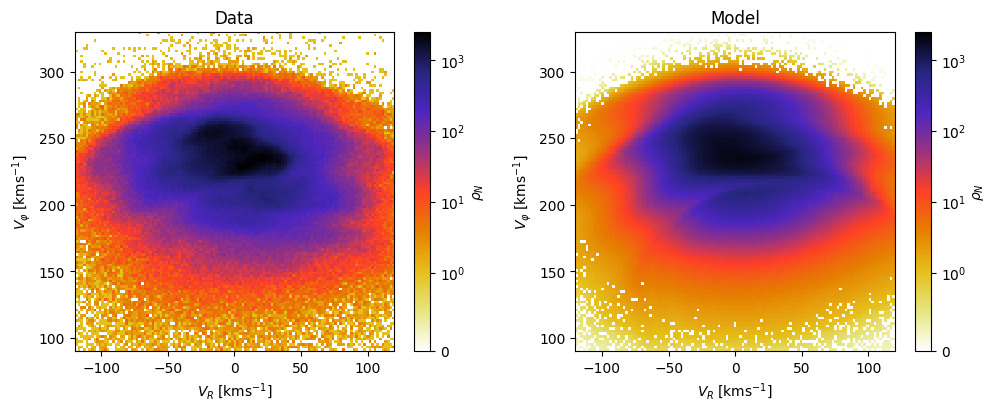

In [3]:
DF_data = np.load('H03.npy')[45:166,40:161]
DF_model = DF_integrator(parameters, x0, y0)
DF_model[DF_data==0] = 0
DF_model = DF_model*np.sum(DF_data)/np.sum(DF_model)

fig, axs = plt.subplots(1,2, figsize = (10,4), constrained_layout=True)

extent = [-120, 120, 90, 330]

axs_DF = axs[0]
im_DF = axs_DF.imshow(DF_data, interpolation='nearest', origin='lower', aspect="equal", cmap=plt.cm.CMRmap_r, norm = mpl.colors.SymLogNorm(linthresh=10**0, linscale=10**0, vmin=0, vmax=np.max(DF_data), base=10), extent=extent)
plt.colorbar(im_DF, ax=axs_DF,label = r'$\mathit{\rho}_\mathit{N} $')
axs_DF.set_title('Data')
axs_DF.set_ylabel(r'$\mathit{V}_{\mathit{\varphi}} \; [\mathsf{kms^{-1}}]$')
axs_DF.set_xlabel(r'$\mathit{V}_{\mathit{R}} \; [\mathsf{kms^{-1}}]$')

axs_DF_2 = axs[1]
im_DF_2 = axs_DF_2.imshow(DF_model, interpolation='nearest', origin='lower', aspect="equal", cmap=plt.cm.CMRmap_r, norm = mpl.colors.SymLogNorm(linthresh=10**0, linscale=10**0, vmin=0, vmax=np.max(DF_data), base=10), extent=extent)
plt.colorbar(im_DF_2, ax=axs_DF_2,label = r'$\mathit{\rho}_\mathit{N} $')
axs_DF_2.set_title('Model')
axs_DF_2.set_ylabel(r'$\mathit{V}_{\mathit{\varphi}} \; [\mathsf{kms^{-1}}]$')
axs_DF_2.set_xlabel(r'$\mathit{V}_{\mathit{R}} \; [\mathsf{kms^{-1}}]$')

# Plotting the median radial velocity map

Text(0.5, 0, '$\\mathit{x} \\; [\\mathsf{kpc}]$')

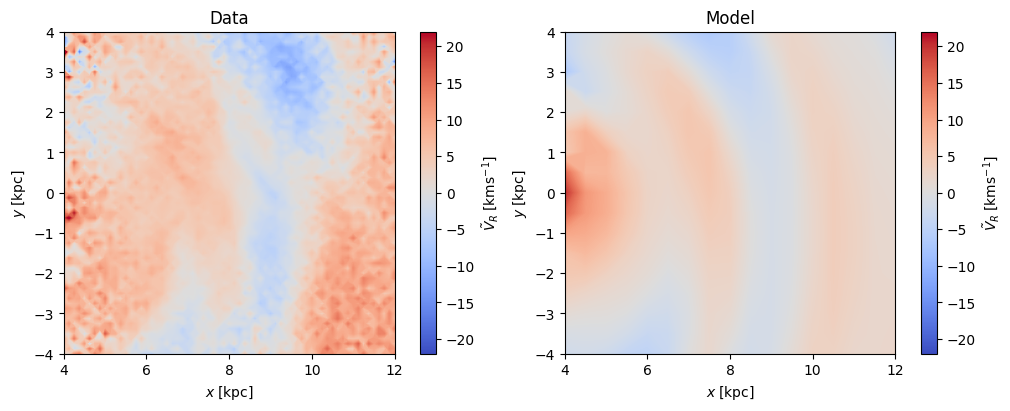

In [4]:
bins_model = 32+1
VR_map_model = np.load('VR_map_model.npy')
x_model = np.linspace(4,12, bins_model, endpoint = True)
y_model = np.linspace(-4,4, bins_model, endpoint = True)
VR_map_model = Vr_map(x_model, y_model, parameters).reshape(bins_model,bins_model).T

VR_maps_data = np.load('VR03.npy').T
bins_data = 64+1
x_data = np.linspace(4,12, bins_data, endpoint = True)
y_data = np.linspace(-4,4, bins_data, endpoint = True)

fig, axs = plt.subplots(1,2, figsize = (10,4), constrained_layout=True)

level_boundaries = np.linspace(-22, +22, 500, endpoint = True)

axs_VR = axs[0]
im_VR = axs_VR.contourf(x_data,y_data,VR_maps_data,level_boundaries, cmap=cm.coolwarm)
plt.colorbar(im_VR, ax=axs_VR, ticks=[-20., -15, -10.,  -5.,  0., 5.,  10., 15, 20.],label=r'$\mathit{\tilde{V}}_{\mathit{R}} \; [\mathsf{kms^{-1}}]$')
axs_VR.set_title('Data')
axs_VR.set_xlim(4, 12)
axs_VR.set_ylim(-4, 4)
axs_VR.set_ylabel(r'$\mathit{y} \; [\mathsf{kpc}]$')
axs_VR.set_xlabel(r'$\mathit{x} \; [\mathsf{kpc}]$')

axs_VR_2 = axs[1]
im_VR_2 = axs_VR_2.contourf(x_model,y_model,VR_map_model,level_boundaries, cmap=cm.coolwarm)
plt.colorbar(im_VR_2, ax=axs_VR_2, ticks=[-20., -15, -10.,  -5.,  0., 5.,  10., 15, 20.],label=r'$\mathit{\tilde{V}}_{\mathit{R}} \; [\mathsf{kms^{-1}}]$')
axs_VR_2.set_title('Model')
axs_VR_2.set_xlim(4, 12)
axs_VR_2.set_ylim(-4, 4)
axs_VR_2.set_ylabel(r'$\mathit{y} \; [\mathsf{kpc}]$')
axs_VR_2.set_xlabel(r'$\mathit{x} \; [\mathsf{kpc}]$')